# Classification with Kernel Density Matrices

This notebook illustrates how to use [Kernel Density Matrices](https://github.com/fagonzalezo/kdm) for classification.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_core as keras
from keras_core.layers import Input, Dense
from keras_core.models import Model
from keras_core import optimizers
from keras_core import losses
from keras_core import metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import kdm


Using TensorFlow backend


In [2]:
'''
Create a 2 moons dataset 
'''


# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_42859/1052752255.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


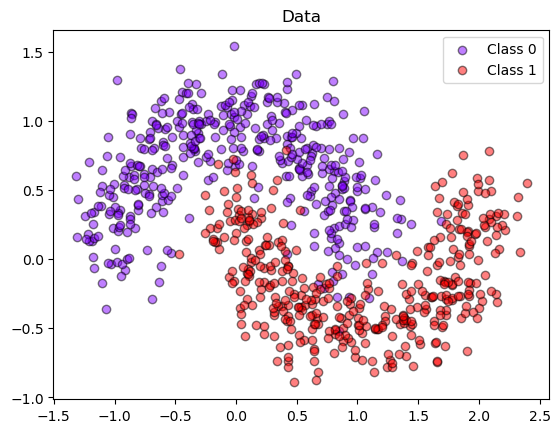

In [3]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

plot_data(X_train, y_train)

## A shallow model 

We use the QKMClassModel to train a shallow model that directly apply a QKM inference layer to the raw data. 

In [4]:
from kdm.models import KDMClassModel


encoded_size = 2
dim_y = 2
encoder = keras.layers.Identity()
n_comp = 10

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
kdm_model.predict(X_train[:10])
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=True)

kdm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.6876 - sparse_categorical_accuracy: 0.5973
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6863
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6010 - sparse_categorical_accuracy: 0.6841
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5630 - sparse_categorical_accuracy: 0.7300
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5649 - sparse_categorical_accuracy: 0.6977
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5236 - sparse_categorical_accuracy: 0.7262
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4998 - sparse_categorical_accuracy: 0.7089
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4570 - sparse_categorical_accuracy: 0.7335
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3818 - sparse_categorical_accuracy: 0.7744
Epoch 10/25
25/25 ━━━━━━━━━━

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
8.106796e-06 8.106796e-06


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_42859/1052752255.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


Test loss: 0.26725056767463684
Test accuracy: 0.8849999904632568
Train loss: 0.2911969721317291
Train accuracy: 0.8949999809265137
Sigma: 0.3750315308570862


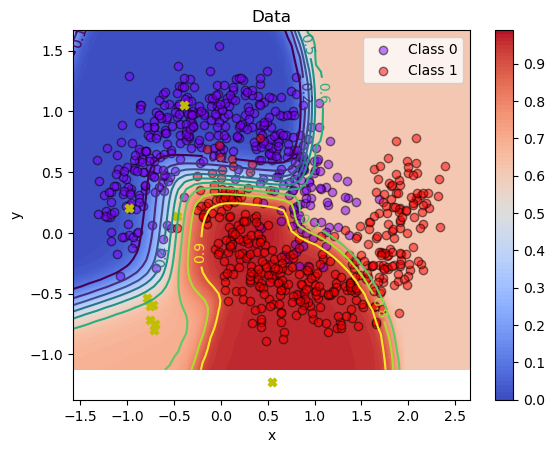

In [5]:
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = kdm_model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')


The model learn a joint QKM that can be seen as a set of prototypes, which are pairs of x and y values. The prototypes are shown in the plot above as yellow crosses. The model also learn a set of weights that are used to combine the prototypes to make predictions.

## MLE training 

We use another alternative to train the model, maximum likelihood estimation (MLE) of the joint probabilities of the input and the output. For this we use the QKMJointDenEstModel class. It uses a QKMProjLayer that calculates the projection of a sample to the space defined by the Layer QKM. The value of this projection can be converted in a probability density multiplying it by the normalizing constants of the corresponding kernel. The class QKMJointDenEstModel uses a Cross Product Kernel (CrossProductKernelLayer) that combines an RBF kernel for the inputs (RBFKernelLayer) and a Cosine kernel (CosineKernelLayer) for the outputs.

In [6]:
# join X and y using a one-hot encoding for y
Xy_train = np.concatenate((X_train, np.eye(2)[y_train]), axis=1)
Xy_test = np.concatenate((X_test, np.eye(2)[y_test]), axis=1)

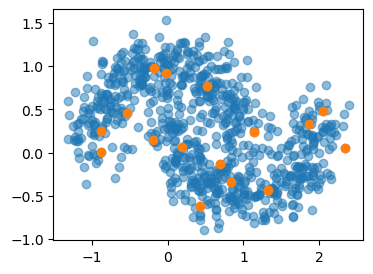

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.3426
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2860
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3526
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0023
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8951
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8046
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7401
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7353
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6985
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7086
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6921
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6991
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7333
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6875
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6911
Epoch 16/100
8/8 ━━

In [7]:
from kdm.models import KDMJointDenEstModel


dim_x = 2
dim_y = 2
sigma = 0.1
n_comp = 16 
kdm_mle = KDMJointDenEstModel(dim_x=dim_x, dim_y=dim_y, sigma=sigma, n_comp=n_comp)

optimizer = keras.optimizers.Adam(learning_rate=5e-3)
kdm_mle.compile(optimizer=optimizer)
# kqmd_model2.predict(Xy_train[:1]) # initialize the model
idx = np.random.randint(Xy_train.shape[0], size=n_comp)
kdm_mle.init_components(Xy_train[idx], sigma=sigma) 


# Plot initial prototypes
centroids = kdm_mle.kdmproj.c_x.numpy()
fig = plt.figure(figsize=(4, 3))
plt.scatter(Xy_train[:, 0], Xy_train[:, 1], alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o')
plt.show()

kdm_mle.fit(Xy_train, epochs=100, verbose=1, batch_size=100)


Now we create a classifier model based on the density estimation model. 

In [8]:
kdm_model2 = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

kdm_model2.kdm.c_x.assign(kdm_mle.kdmproj.c_x[:, 0:2])
kdm_model2.kdm.c_y.assign(kdm_mle.kdmproj.c_x[:, 2:4])
kdm_model2.kdm.c_w.assign(kdm_mle.kdmproj.c_w)
kdm_model2.kernel.sigma.assign(kdm_mle.kernel_x.sigma)

kdm_model2.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1.2902533e-05 1.2902533e-05


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_42859/1052752255.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


Test loss: 0.05714073404669762
Test accuracy: 0.9750000238418579
Train loss: 0.08833850920200348
Train accuracy: 0.96875
Sigma: 0.2855178713798523


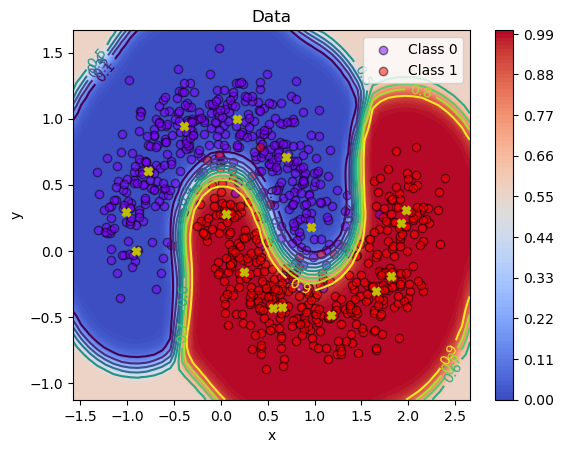

In [9]:
plot_decision_region(X, gen_pred_fun(kdm_model2))
plot_data(X_train, y_train)
# plot the prototypes
comp_w = keras.ops.abs(kdm_model2.kdm.c_w) + 1e-6
comp_w = comp_w / keras.ops.sum(comp_w)
prototypes = keras.ops.convert_to_numpy(kdm_model2.kdm.c_x[comp_w > 0.01])
plt.scatter(prototypes[:, 0], prototypes[:, 1], 
             c='y', marker='X')
# Evaluate the classifier
score = kdm_model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = kdm_model2.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {kdm_model2.kernel.sigma.numpy()}')


The above visualization shows the decision boundary of the classifier model along with the prototypes of the model. Only prototypes with a weight greater than 0.01 are shown. The prototypes are shown as yellow crosses. Because of the likelihood maximization, prototypes are distributed evenly in the input space to maximize the density of the input samples. The classification performance in on par with the discriminative model.

## MNIST example

An example using the mnist dataset. In addition to perform classification we will show how to perform generation.

In [10]:
# Create a dataset from mnist using tf
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# reshape the data to include a channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Partition the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
      x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
      fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
      axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
      axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


We define a deep encoder that will be used to map input images to a low-dimensional latent space.

In [ ]:
tfkl = keras.layers

def create_encoder(input_shape, base_depth, encoded_size):
    encoder = keras.Sequential([
        tfkl.InputLayer(shape=input_shape),
        tfkl.Lambda(lambda x: x - 0.5),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=keras.ops.leaky_relu),
        tfkl.Dense(encoded_size,
                activation=None),#, activity_regularizer=tf.keras.regularizers.l2(1e-3)),
        #tfkl.layers.LayerNormalization(),
        tfkl.Flatten(),
    ])
    return encoder

The classifier model (QKMClassModel) receives as input the encoder, and applies it before applying the QKM inference layer.

In [46]:
# Define the encoder
input_shape = (28, 28, 1)
base_depth = 32
encoded_size = 2
encoder = create_encoder(input_shape, base_depth, encoded_size)

# warm up the 
encoder_wmp = keras.Sequential([encoder, 
                                  keras.layers.Dense(10, activation='softmax')])
encoder_wmp.predict(X_train[:10])
encoder_wmp.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                loss=losses.sparse_categorical_crossentropy,
                metrics=[metrics.sparse_categorical_accuracy])
#encoder_wmp.fit(X_train, y_train, epochs=1, batch_size=64, verbose=1)
# Create a classifier model
dim_y = 10
n_comp = 64

kdm_mnist = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

# initialize the prototypes using random samples from the training set
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_mnist.init_components(X_train[idx], keras.ops.one_hot(y_train[idx], 10), 
                          init_sigma=True, sigma_mult=10)

print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

# Compile the model
kdm_mnist.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 1.6755 - sparse_categorical_accuracy: 0.3692
Sigma: 210.37734985351562


In [47]:
# Train the model
kdm_mnist.fit(X_train, y_train, validation_data=(X_val[:1000], y_val[:1000]), epochs=10, batch_size=128, verbose=1)
print(f'Final Sigma: {kdm_mnist.kernel.sigma.numpy()}')


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - loss: 2.1443 - sparse_categorical_accuracy: 0.2445 - val_loss: 1.9625 - val_sparse_categorical_accuracy: 0.2800
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 1.9390 - sparse_categorical_accuracy: 0.2604 - val_loss: 1.9076 - val_sparse_categorical_accuracy: 0.3270
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 1.8904 - sparse_categorical_accuracy: 0.2936 - val_loss: 1.8969 - val_sparse_categorical_accuracy: 0.2820
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.8703 - sparse_categorical_accuracy: 0.2872 - val_loss: 1.8721 - val_sparse_categorical_accuracy: 0.2670
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 1.8474 - sparse_categorical_accuracy: 0.3217 - val_loss: 1.8577 - val_sparse_categorical_accuracy: 0.3370
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 1.8372 - sparse_categorical_accuracy: 0.3291 - val_loss: 1.8539 - val_sparse_categorical_accuracy: 0.3530
Epoc

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


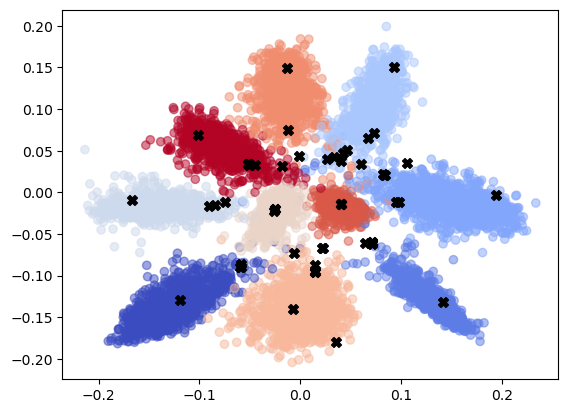

In [26]:
num_samples = 10000
encoded_samples = keras.ops.convert_to_numpy(encoder.predict(X_train[:num_samples]))
# Visualize the points in the feature space
plt.scatter(encoded_samples[:, 0], encoded_samples[:, 1], alpha=0.5, c=y_train[:num_samples], cmap=plt.cm.coolwarm)

prototypes = keras.ops.convert_to_numpy(kdm_mnist.kdm.c_x)
# plot the prototypes
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='k', marker='X', s=50)
plt.show()

The figure above show training samples mapped to the latent space with different colors according to the class. The prototypes are shown as black crosses. Note that the prototypes do not cover all the areas of the different classes in the latent space, rather they are positioned to maximize the classification performance.

In [27]:
# Evaluate the classifier
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

Test loss: 0.19642844796180725
Test accuracy: 0.9541000127792358
Train loss: 0.06090366467833519
Train accuracy: 0.984416663646698
Sigma: 0.025531351566314697


Now we will train a density estimation model using the QKMJointDenEstModel class and keeping the encoder fix. This model maximizes the joint likelihood of inputs and outputs. The goal is to obtain more representative prototypes, since the prototypes learned using the classification model are not representative of the data distribution, since them are optimized to maximize the classification accuracy.

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


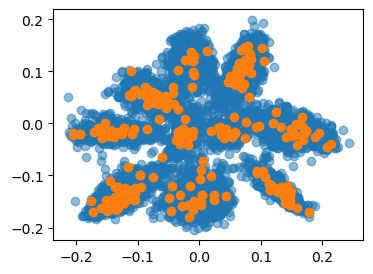

Sigma: 0.025531351566314697
Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 1.0402
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9356
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9105
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9155
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8976
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9039
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9119
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.9023
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9158
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.8890
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9190
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.8972
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.9062
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9109
Epoch 15/20
120

In [28]:
# join X and y using a one-hot encoding for y
X_encoded = keras.ops.convert_to_numpy(encoder.predict(X_train))
Xy_train = np.concatenate((X_encoded, 
                          np.eye(10)[y_train]), 
                          axis=1)
dim_x = encoded_size
sigma = kdm_mnist.kernel.sigma.numpy()
n_comp = 256
kdm_mle_mnist = KDMJointDenEstModel(dim_x=dim_x, dim_y=dim_y, sigma=sigma, n_comp=n_comp)

optimizer = optimizers.Adam(learning_rate=1e-3)

# kqmd_model2.predict(Xy_train[:1]) # initialize the model
idx = np.random.randint(Xy_train.shape[0], size=n_comp)
kdm_mle_mnist.init_components(Xy_train[idx], sigma=sigma) 


# Plot initial prototypes
centroids = kdm_mle_mnist.kdmproj.c_x.numpy()
fig = plt.figure(figsize=(4, 3))
plt.scatter(Xy_train[:, 0], Xy_train[:, 1], alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o')
plt.show()

kdm_mle_mnist.compile(optimizer=optimizer)

print(f'Sigma: {kdm_mle_mnist.kernel_x.sigma.numpy()}')

kdm_mle_mnist.fit(Xy_train, epochs=20, verbose=1, batch_size=100)

print(f'Final Sigma: {kdm_mle_mnist.kernel_x.sigma.numpy()}')



Now we use the parameters learned by the Maximum Likelihood model to create a QKM classifier. This classifier is not trained, but it is initialized with the parameters learned by the MLE model.

In [29]:
kdm_mnist2 = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

kdm_mnist2.kdm.c_x.assign(kdm_mle_mnist.kdmproj.c_x[:, 0:encoded_size])
kdm_mnist2.kdm.c_y.assign(kdm_mle_mnist.kdmproj.c_x[:, encoded_size:])
kdm_mnist2.kdm.c_w.assign(kdm_mle_mnist.kdmproj.c_w)
kdm_mnist2.kernel.sigma.assign(kdm_mle_mnist.kernel_x.sigma)


# Compile the model
kdm_mnist2.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Evaluate the classifier
score = kdm_mnist2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = kdm_mnist2.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {kdm_mnist2.kernel.sigma.numpy()}')

Test loss: 0.19062140583992004
Test accuracy: 0.9584000110626221
Train loss: 0.0435660257935524
Train accuracy: 0.9879999756813049
Sigma: 0.012658837251365185


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


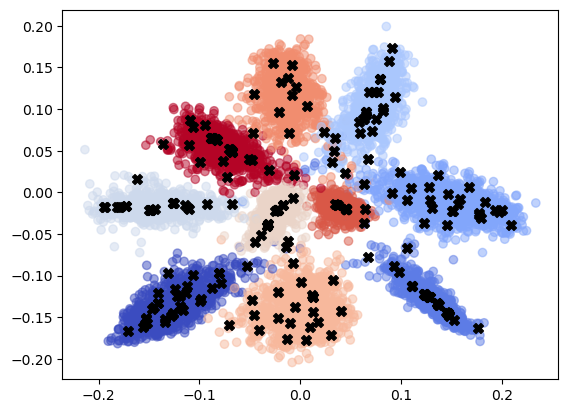

In [30]:
num_samples = 10000
encoded_samples = keras.ops.convert_to_numpy(encoder.predict(X_train[:num_samples]))
# Visualize the points in the feature space
plt.scatter(encoded_samples[:, 0], encoded_samples[:, 1], alpha=0.5, c=y_train[:num_samples], cmap=plt.cm.coolwarm)

prototypes = keras.ops.convert_to_numpy(kdm_mnist2.kdm.c_x)
# plot the prototypes
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='k', marker='X', s=50)
plt.show()

## Generator model

We can build a generator taking advantage of the symmetry of the QKM layer. Basically we change the role of the x-prototypes and the y-prototypes. The entry to the model will be a 10D vector that represents probability distribution of the digits to generate . The output of the QKM layer will be a probability distribution on the latent space. We can sample from this distribution to generate new samples that we will decode to obtain the generated digit. First we will train a decoder.

In [31]:

def create_decoder(base_depth, encoded_size):
    decoder = keras.Sequential([
        tfkl.InputLayer(shape=[encoded_size]),
        tfkl.Reshape([1, 1, encoded_size]),
        tfkl.Conv2DTranspose(2 * base_depth, 6, strides=1,
                            padding='valid', activation=keras.ops.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                            padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, dilation_rate=2,
                            padding='valid', activation=keras.ops.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                            padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, dilation_rate=2,
                            padding='valid', activation=keras.ops.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 4, dilation_rate=2,
                            padding='valid', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                    padding='same', activation=None),    
    ])
    return decoder

decoder = create_decoder(base_depth, encoded_size)
inputs = keras.layers.Input(shape=input_shape)
ae_model = keras.Sequential([inputs,
                            encoder,
                            decoder                            
                           ])
encoder.trainable = False

ae_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
            loss=losses.BinaryCrossentropy(from_logits=True))

ae_model.fit(X_train, X_train, epochs=20, batch_size=32, verbose=0)

Let's plot some generated digits. The digits generated from the autoencoder are fuzzy because of the small dimension of the latent space. 

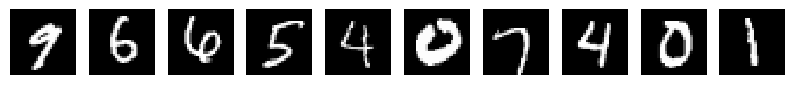

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


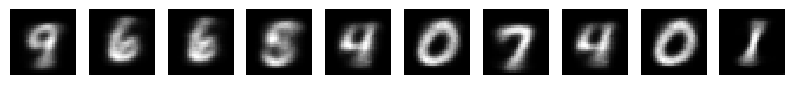

In [32]:
display_imgs(X_test[20:30])
prediction = ae_model.predict(X_test[20:30])

prediction = keras.ops.convert_to_numpy(
    keras.ops.sigmoid(prediction))
display_imgs(prediction)

Now we define the generator model. It receives a 10D vector that represents the probability distribution of the digits to generate. The output of the QKM layer is a probability distribution on the latent space. We can sample from this distribution to generate new samples that we will decode to obtain the generated digit. 

In [33]:
from kdm.layers import CosineKernelLayer, KDMLayer

def create_generator_model(clf_model):
        inputs_gen = Input(shape=(10,))
        kernel_gen = CosineKernelLayer()
        kdm_gen = KDMLayer(kernel=kernel_gen, 
                                   dim_x=10, 
                                   dim_y=clf_model.encoded_size, 
                                   n_comp=clf_model.n_comp)
        kdm_gen.c_x.assign(clf_model.kdm.c_y)
        kdm_gen.c_y.assign(clf_model.kdm.c_x)
        kdm_gen.c_w.assign(clf_model.kdm.c_w)
        rho_y_gen = kdm.utils.pure2dm(inputs_gen)
        rho_x_gen = kdm_gen(rho_y_gen)
        gen_model = Model(inputs_gen, rho_x_gen)
        return gen_model

gen_model = create_generator_model(kdm_mnist2)
gen_model.compile()

In [34]:
import tensorflow_probability as tfp
tfd = tfp.distributions

def dm2distrib(dm, sigma):
    '''
    Creates a Gaussian mixture distribution from the components of a density
    matrix with an RBF kernel 
    Arguments:
     dm: tensor of shape (bs, n, d + 1)
     sigma: sigma parameter of the RBF kernel 
    Returns:
     gm: mixture of Gaussian distribution with shape (bs, )
    '''
    w, v = kdm.utils.dm2comp(dm)
    gm = tfd.MixtureSameFamily(reparameterize=True,
            mixture_distribution=tfd.Categorical(
                                    probs=w),
            components_distribution=tfd.Independent( tfd.Normal(
                    loc=v,  # component 2
                    scale=sigma / np.sqrt(2.)),
                    reinterpreted_batch_ndims=1))
    return gm

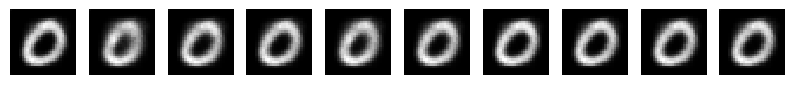

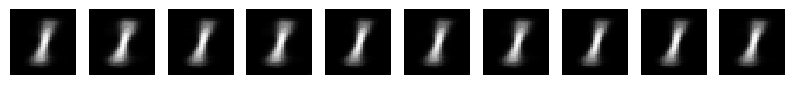

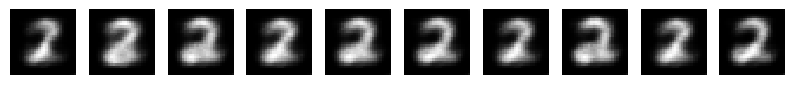

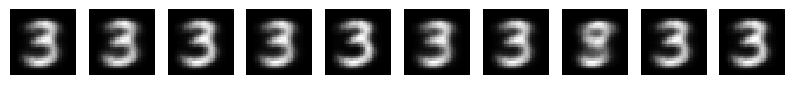

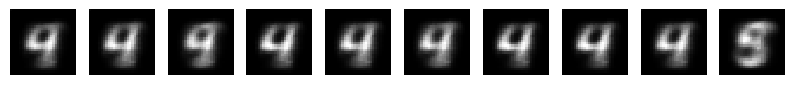

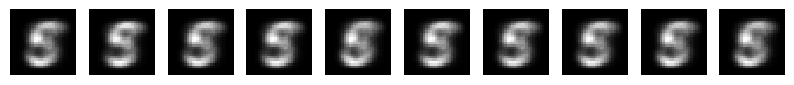

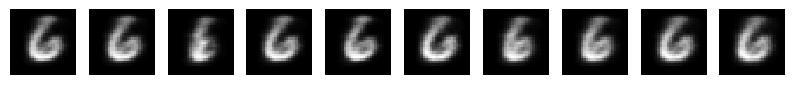

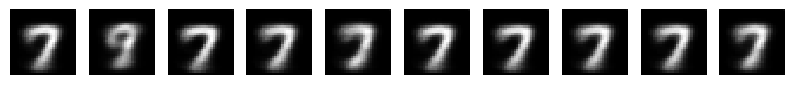

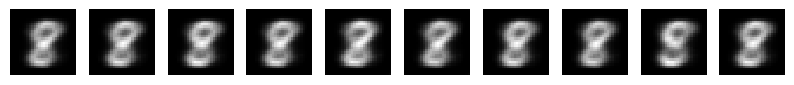

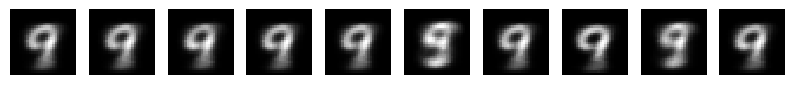

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


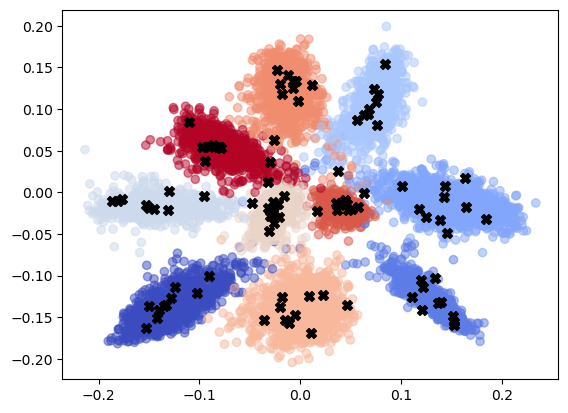

In [41]:
# Generate a set of distributions from the model for each digit
rho_y = keras.ops.convert_to_numpy(
    gen_model(keras.ops.eye(10)))
rho_y = np.float64(rho_y)

sigma = keras.ops.convert_to_numpy(kdm_mnist2.kernel.sigma)
sigma = np.float64(sigma)

distribs = dm2distrib(rho_y, sigma=sigma)
# Sample from the distributions
samples = []
for i in range(10):
    sample = distribs[i].sample(10).numpy()
    samples.append(sample)
    # Show the decoded images
    decoded_imgs = decoder(sample)
    decoded_imgs = keras.ops.convert_to_numpy(
        keras.ops.sigmoid(decoded_imgs))
    display_imgs(decoded_imgs)

# plot the samples in the feature space
num_train_samples = 10000
encoded_train = keras.ops.convert_to_numpy(encoder.predict(X_train[:num_train_samples]))

plt.scatter(encoded_train[:, 0], encoded_train[:, 1], alpha=0.5, 
            c=y_train[:num_train_samples], cmap=plt.cm.coolwarm)

# plot the prototypes
samples = np.concatenate(samples)
plt.scatter(samples[:, 0], samples[:, 1], c='k', marker='X', s=50)
plt.show()


Now we will generate digits from a label distribution that is a mixture of two digits. We will generate digits that are a mixture of 0 and 1. 

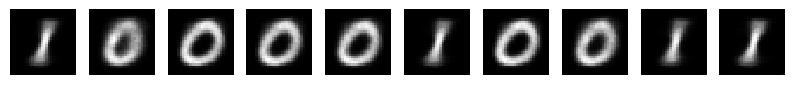

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


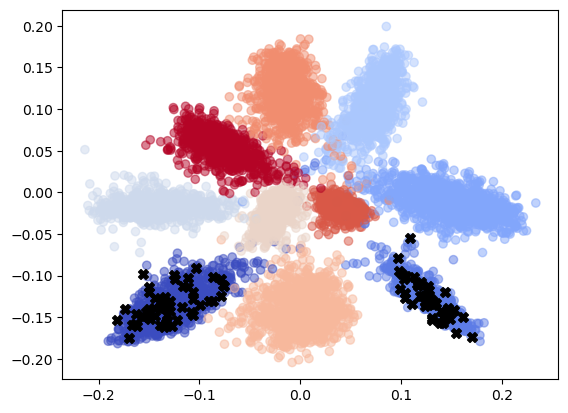

In [42]:
# Generate a set of distributions from the model for each digit
y_distrib = np.zeros((1,10))
y_distrib[0, 0] = 1 / np.sqrt(2)
y_distrib[0, 1] = 1 / np.sqrt(2)
rho_y = keras.ops.convert_to_numpy(
    gen_model(y_distrib))
rho_y = np.float64(rho_y)
x_distrib = dm2distrib(rho_y, sigma=sigma)[0]
# Sample from the distributions
sample = x_distrib.sample(100).numpy()
# Show the decoded images
decoded_imgs = decoder(sample[:10])
decoded_imgs = keras.ops.convert_to_numpy(
        keras.ops.sigmoid(decoded_imgs))
display_imgs(decoded_imgs)

# plot the samples in the feature space
num_train_samples = 10000
encoded_train = keras.ops.convert_to_numpy(encoder.predict(X_train[:num_train_samples]))

plt.scatter(encoded_train[:, 0], encoded_train[:, 1], alpha=0.5, 
            c=y_train[:num_train_samples], cmap=plt.cm.coolwarm)

# plot the prototypes
plt.scatter(sample[:, 0], sample[:, 1], c='k', marker='X', s=50)
plt.show()
